# Large textural dataset analysis - Skuggafjoll

In [4]:
#Load in the data from the segmentation results
import numpy as np
import matplotlib.pyplot as plt
import piecewise_regression
samples = ["HOR11_01A", "HOR11_01B", "HOR11_01C", "HOR11_02A", "HOR11_02B", "HOR12_03A", "HOR12_03B", "SKU11_02A" ,
            "SKU11_02B", "SKU11_03", "SKU12_05", "SKU12_06A", "SKU12_06B", "SKU12_07","SKU12_09A", "SKU12_09B","SKU12_09C", "SKU12_14B", "SKU12_15B",
             "SKU12_15A", "SKU12_15B", "SKU12_15C", "SKU12_16","SKU12_21",  "SKU12_22","SKU12_25", "SKU12_26"]


centres = []
tex_counts = []
tex_centres = []
area_sqrt = []
aspect_ratio = []
aspect_ratio_sigma = []
for item in samples:
    tex = np.load("data/data_geo_" + str(item) + ".npz")
    counts = tex["counts"]
    counts_x = tex["centres"]
    ar = tex["arb"]
    ars = tex["ars"]
    asqrt = tex["ar_centres"]
    tex_counts.append(counts)
    tex_centres.append(counts_x)
    aspect_ratio.append(ar)
    area_sqrt.append(asqrt)
    aspect_ratio_sigma.append(ars)

In [6]:
#calculate bin widths

def get_bw(centres, min_size = 0):
    bw = []
    for i in range(len(centres)):
        if i == 0:
            bw.append(centres[i]-min_size)
        else:
            bw.append(centres[i]-centres[i-1])

    return np.asarray(bw)

bw_list = []
for item in tex_centres:
    bw_list.append(get_bw(item, min_size = 100))

In [7]:
#piecewise regression fits - 2 samples don't have any breakpoints so a custom function was written to bypass it

def no_bp_fit(x_plot, y_plot):
    ms = piecewise_regression.ModelSelection(x_plot, y_plot, max_breakpoints = 1)
    const = ms.model_summaries[0]["estimates"]["const"]
    alpha = ms.model_summaries[0]["estimates"]["alpha1"]
    return const, alpha

bp = []
alpha1 = []
alpha2 = []
se = []
alpha = []
consts = []
max_x = []
min_x = []
pw_fit_list = []


for i in range(len(samples)):
    
    y_plot = np.log(np.divide(tex_counts[i]/0.15, bw_list[i]*0.0001))
    x_plot = tex_centres[i]


    if samples[i] == "SKU12_05":
        c, a = no_bp_fit(x_plot, y_plot)
        alpha.append(a)
        consts.append(c)
        max_x.append(np.max(x_plot))
        min_x.append(np.min(x_plot))
    elif samples[i] == "SKU12_25":
        c, a = no_bp_fit(x_plot, y_plot)
        alpha.append(a)
        consts.append(c)
        max_x.append(np.max(x_plot))
        min_x.append(np.min(x_plot))
    else:
    
        pw_fit = piecewise_regression.Fit(x_plot, y_plot, n_breakpoints=1)
        res = pw_fit.get_results()["estimates"]
        bp.append(res["breakpoint1"]["estimate"])
        alpha1.append(res["alpha1"]["estimate"])
        alpha2.append(res["alpha2"]["estimate"])
        se.append([res["breakpoint1"]["se"],res["alpha1"]["se"],res["alpha2"]["se"]])
        pw_fit_list.append(pw_fit)

        
        # Plot the data, fit, breakpoints and confidence intervals
        #pw_fit.plot_data(color="grey", s=20)
        # Pass in standard matplotlib keywords to control any of the plots
        #pw_fit.plot_fit(color="red", linewidth=2)
        #plt.xlabel("x")
        #plt.ylabel("y")
bp = np.asarray(bp)
se = np.asarray(se)
alpha1=np.asarray(alpha1)
alpha2 = np.asarray(alpha2)

Running fit with n_breakpoint = 0 . . 
Running fit with n_breakpoint = 1 . . 

                 Breakpoint Model Comparision Results                 
n_breakpoints            BIC    converged          RSS 
----------------------------------------------------------------------------------------------------
0                    -19.266         True      0.42799 
1                                   False              

Min BIC (Bayesian Information Criterion) suggests best model
Running fit with n_breakpoint = 0 . . 
Running fit with n_breakpoint = 1 . . 

                 Breakpoint Model Comparision Results                 
n_breakpoints            BIC    converged          RSS 
----------------------------------------------------------------------------------------------------
0                    -18.204         True      0.48875 
1                    -15.579         True      0.40346 

Min BIC (Bayesian Information Criterion) suggests best model


### Visualize results

In [9]:
def mc_average(means, sigmas, n = 100000):
    m = np.random.randint(0, len(means), n)
    samples = np.random.normal(loc = means[m], scale = sigmas[m])
    return np.mean(samples), np.std(samples)

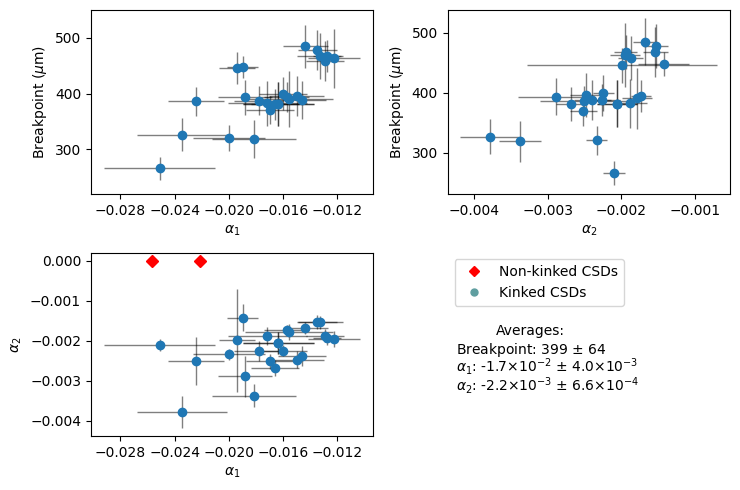

In [14]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(2,2,figsize=(7.5, 5))
ax1 = ax[0,0]
ax2 = ax[0,1]
ax3 = ax[1,0]
ax[1,1].axis("off")

scatter_kwargs = {"zorder":100}
error_kwargs = {"lw":1, "zorder":0}
ax1.errorbar(alpha1, bp, xerr = se[:,1], yerr = se[:,0], fmt = 'none', alpha = 0.5, c = 'k' , **error_kwargs)
ax1.scatter(alpha1, bp,c = 'tab:blue' , **scatter_kwargs)
ax1.plot(alpha, [0,0], 'rD')
ax1.set_ylim([220, 550])

ax2.errorbar(alpha2, bp, xerr = se[:,2], yerr = se[:,0], fmt = 'none', alpha = 0.5, c = 'k' , **error_kwargs)
ax2.scatter(alpha2, bp,c = 'tab:blue' , **scatter_kwargs)

ax3.errorbar(alpha1, alpha2, xerr = se[:,1], yerr = se[:,2], fmt = 'none', alpha = 0.5, c = 'k' , **error_kwargs)
ax3.scatter(alpha1, alpha2,c = 'tab:blue' , **scatter_kwargs)
ax3.plot(alpha, [0,0], 'rD')

ax1.xaxis.set_major_locator(MultipleLocator(0.004))
ax2.xaxis.set_major_locator(MultipleLocator(0.001))
ax3.xaxis.set_major_locator(MultipleLocator(0.004))

ax1.set_ylabel(r"Breakpoint ($\mu$m)")
ax2.set_ylabel(r"Breakpoint ($\mu$m)")
ax3.set_ylabel(r"$\alpha_2$")

ax1.set_xlabel(r"$\alpha_1$")
ax2.set_xlabel(r"$\alpha_2$")
ax3.set_xlabel(r"$\alpha_1$")

import matplotlib.lines as mlines

red_diamond = mlines.Line2D([], [], color='red', marker='D', linestyle='None',
                          markersize=5, label='Non-kinked CSDs')
dot = mlines.Line2D([], [], color='cadetblue', marker='o', linestyle='None',
                          markersize=5, label='Kinked CSDs')

ax[1,1].legend(handles=[red_diamond, dot], loc = "upper left")
ax[1,1].text(0.17, 0.55, r"Averages:")
ax[1,1].text(0.03, 0.45, r"Breakpoint: 399 $\pm$ 64")
ax[1,1].text(0.03, 0.35, r"$\alpha_1$: -1.7$\times10^{-2}$ $\pm$ 4.0$\times10^{-3}$")
ax[1,1].text(0.03, 0.25, r"$\alpha_2$: -2.2$\times10^{-3}$ $\pm$ 6.6$\times10^{-4}$")

plt.tight_layout()

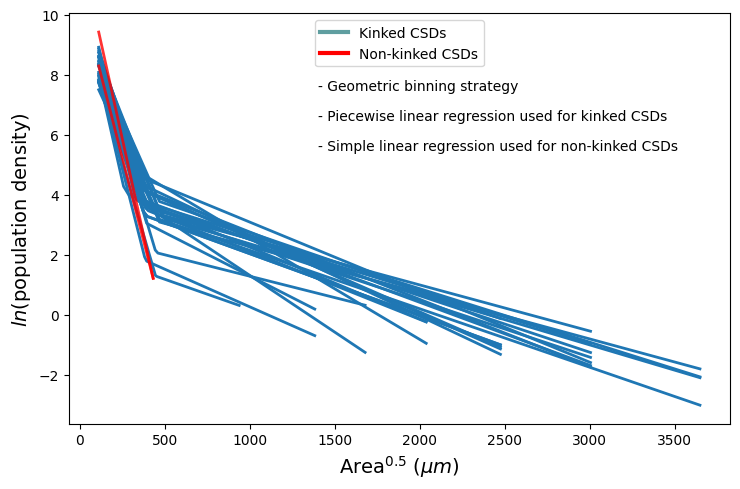

In [15]:
fig = plt.figure(figsize=(7.5, 5))



for pw in pw_fit_list:
    pw.plot_fit(color = "tab:blue", linewidth = 2)

for i in range(len(alpha)):
    a = alpha[i]
    c = consts[i]
    max_val = max_x[i]
    min_val = min_x[i]
    x = np.linspace(min_val, max_val, 20)
    y = c + x*a
    plt.plot(x, y, 'r', alpha = 0.8, linewidth = 2)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="cadetblue", lw=3),
                Line2D([0], [0], color="r", lw=3)]
plt.legend(custom_lines, ["Kinked CSDs", "Non-kinked CSDs"], loc = "upper center")
plt.xlabel(r"Area$^{0.5}$ ($\mu m$)", size = 14)
plt.ylabel("$ln$(population density)", size = 14)
plt.text(1400, 7.5, r"- Geometric binning strategy", size = 10)
plt.text(1400, 6.5, r"- Piecewise linear regression used for kinked CSDs", size = 10)
plt.text(1400, 5.5, r"- Simple linear regression used for non-kinked CSDs", size = 10)
fig.tight_layout()

In [16]:
max_len = 0
index = 0
for i in range(len(aspect_ratio)):
    if len(aspect_ratio[i]) > max_len:
        max_len = len(aspect_ratio[i])
        index = i
    else:
        pass

means = []
stds = []
binned_ar = []
binned_ar_sigma = []
for j in range(max_len):
    temp = []
    temp_sigma = []
    for i in range(len(aspect_ratio)):
        item = aspect_ratio[i]
        if len(item) <= j:
            pass
        else:
            temp.append(item[j])
            temp_sigma.append(aspect_ratio_sigma[j])
    means.append(np.mean(temp))
    stds.append(np.std(temp))
    binned_ar.append(temp)
    binned_ar_sigma.append(temp_sigma)

<ErrorbarContainer object of 3 artists>

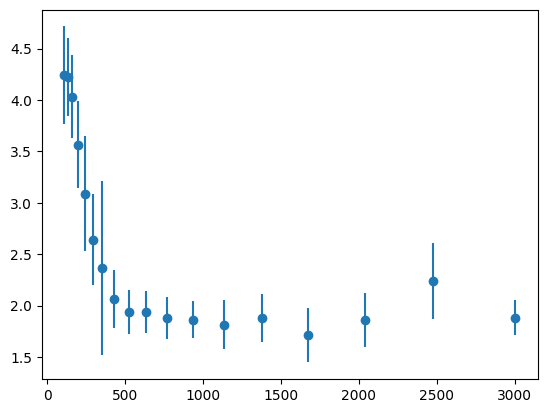

In [17]:
plt.errorbar(tex_centres[index][:max_len], means, yerr=stds, fmt = "o")

### Use MCMC fit from Sill calibration

In [18]:
import bilby
result = bilby.result.read_in_result(filename='mcmc2/unknown_x_result.json')

In [19]:
m = result.posterior["m"].to_numpy()
c = result.posterior["c"].to_numpy()
m_best = np.mean(m)
c_best = np.mean(c)

In [20]:
best_fit = np.asarray(means)*m_best + c_best

In [21]:
realisations = np.asarray(means)*m.reshape(-1,1) + c.reshape(-1,1)

In [22]:
binned_mean = []
binned_std = []
all_realisations = []
for item in binned_ar:
    best_fit = np.asarray(item)*m_best + c_best
    realisations = np.asarray(item)*m.reshape(-1,1) + c.reshape(-1,1)
    binned_mean.append(np.mean(best_fit))
    binned_std.append(np.std(realisations))

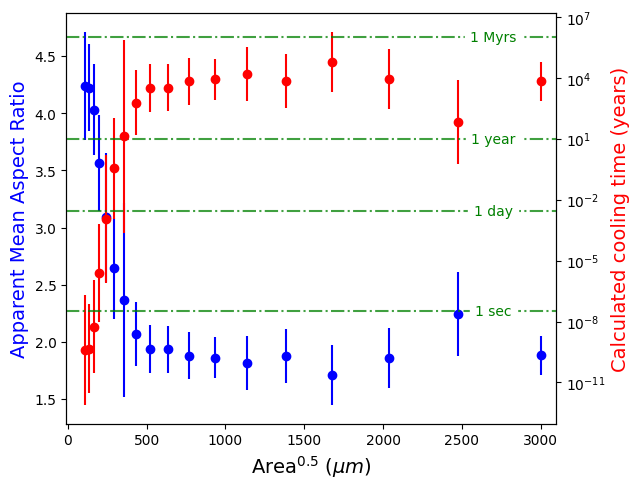

In [25]:
fig, ax = plt.subplots(1,1,figsize=(6.5, 5))

ax.errorbar(tex_centres[index][:max_len], means, yerr=stds, fmt = "o", c = 'b')
ax.set_ylabel("Apparent Mean Aspect Ratio", color = 'b', size = 14)

axt = ax.twinx()
axt.errorbar(tex_centres[index][:max_len], 10**np.asarray(binned_mean), yerr =[10**np.asarray(binned_mean) - 10**(np.asarray(binned_mean)-np.asarray(binned_std)),
                                                                               10**(np.asarray(binned_mean)+np.asarray(binned_std)) - 10**np.asarray(binned_mean)],
                                                                                 fmt = 'o', c = 'r')
axt.set_ylabel("Calculated cooling time (years)", color = "r", size = 14)
ax.set_xlabel(r"Area$^{0.5}$ ($\mu m$)", size = 14)
axt.set_yscale("log")
axt.hlines(10**6,-10, 3100, 'g', linestyle = '-.', alpha = 0.75 )
axt.text(2700, 10**6, '1 Myrs', fontsize=10, va='center', ha='center', backgroundcolor='w', c = 'g')
axt.hlines(10**1,-10, 3100, 'g', linestyle = '-.' , alpha = 0.75 )
axt.text(2700, 10**1, '1 year', fontsize=10, va='center', ha='center', backgroundcolor='w', c = 'g')
axt.hlines(1/365.25,-10, 3100, 'g', linestyle = '-.' , alpha = 0.75 )
axt.text(2700, 1/365.25, '1 day', fontsize=10, va='center', ha='center', backgroundcolor='w', c = 'g')
axt.hlines(1/(365.25*24*3600),-10, 3100, 'g', linestyle = '-.' , alpha = 0.75 )
axt.text(2700, 1/(365.25*24*3600), '1 sec', fontsize=10, va='center', ha='center', backgroundcolor='w', c = 'g')
ax.set_xlim([-10, 3100])
fig.tight_layout()